In [35]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import time, os, pickle
import numpy as np
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.time_series import *
from scripts.ra import *
from scripts.exp_tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

set_seed(313)
save_dir = 'experiments/all_targets'
fig_dir = 'figures/all_targets'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

# 2D systems

## 2 Bounded line attractors

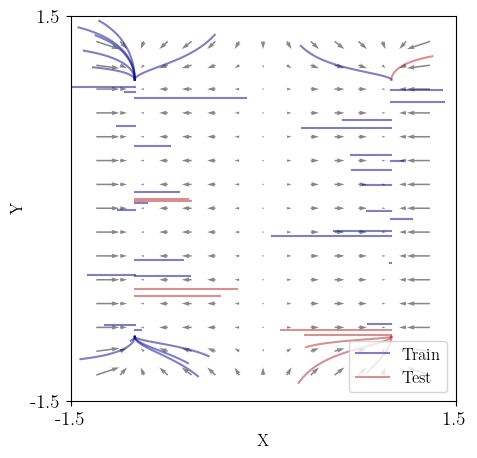

In [84]:
set_seed(313)
dt = 0.1
time_span = torch.tensor([0.0, 2.])
simulation_params = {
        'initial_conditions_mode': 'random',
        'number_of_target_trajectories': 50,
        'noise_std': 0.0,
        'margin': 0.5,
        'seed': 42, }
bi_sys = LearnableNDBistableSystem(dim=1, dt=dt, time_span=time_span) 
la = LearnableBoundedContinuousAttractor(dim=1,bca_dim=1,dt=0.05,time_span=(0, 5))
systems = [bi_sys, la]
dims = [bi_sys.dim, la.dim]
composite_system = LearnableCompositeSystem(systems=systems,dims=dims,dt=0.05,time_span=(0, 5))
init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.5, 1.5)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
bila_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
np.save(f"{save_dir}/bila_trajs.npy", bila_trajs)

inv_man = composite_system.invariant_manifold(100).detach().numpy() 

X, Y, U, V = get_ds_vf(composite_system, bounds=[-1.3, 1.3], num_points=15)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=15)
set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(bila_trajs, train_ratio=.8)

# for i in range(bila_trajs.shape[0]):
#     ax.plot(bila_trajs[i, :, 0], bila_trajs[i, :, 1], '-', color='darkblue', label='Trajectory' if i == 0 else "", markersize=2, alpha=0.5)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0], trajectories_target_train[i, :, 1], color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0], trajectories_target_test[i, :, 1], color='firebrick', alpha=0.5, label='Test' if i==0 else "")
# ax.plot(inv_man[:, 0], inv_man[:, 1], '.', color='C3', lw=2, label='Invariant Manifold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_yticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_aspect('equal')
#ax.set_title('Bistable System')
ax.legend(loc='lower right') #, bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.savefig(fig_dir + '/twoblas_vf_trajs.pdf', bbox_inches='tight')


In [36]:
# bla_pert_folder = 'experiments/bla_pert/'
# os.makedirs(bla_pert_folder, exist_ok=True)
# set_seed(313)
# for epsilon in np.linspace(0, .5, 11):
#     epsilon = np.round(epsilon, 2)
#     W = torch.tensor([[0, -1],[-1,0]], dtype=torch.float32) + epsilon*torch.tensor([[1, -2],[-2,1]], dtype=torch.float32)
#     b = torch.tensor([1,1], dtype=torch.float32)
#     bla_system = BoundedLineAttractor(W=W, b=b, dim=2, dt=0.1, time_span=torch.tensor([0.0, 5.]))
#     t_values, trajectories_target, initial_conditions_target = generate_trajectories(sampling_method='uniform', init_points_bounds=[(-1,1)]*2, system=bla_system, num_points=50)   
#     # fig, ax = plt.subplots(figsize=(5,5))
#     # for i in range(trajectories_target.shape[0]):
#     #     ax.plot(trajectories_target[i, :, 0], trajectories_target[i, :, 1], color='black', alpha=0.2)

#     np.save(f"{bla_pert_folder}/epsilon{epsilon}.npy", trajectories_target.detach().numpy())
#     # with open(f"{bla_pert_folder}/simulation_params_nstd{epsilon}.pkl", "wb") as f:
#     #     pickle.dump(, f)

In [ ]:
# ## 2 line attractor
# bla_pert_folder = 'experiments/bla_pert/'
# os.makedirs(bla_pert_folder, exist_ok=True)


# Limit cycles

### Van der Pol oscillator

#### Deterministic VdP

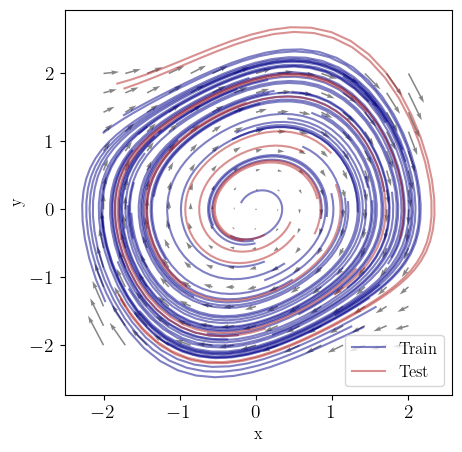

In [38]:
# generate trajectories for Van der Pol target system
set_seed(313)

system_name = 'vdp'
simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
    'noise_std': 0.0,  # Noise level for the simulation
}
vdp_system = VanDerPol(mu=simulation_params['mu'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)
X, Y, U, V = get_ds_vf(vdp_system, bounds=[-2.0, 2.0], num_points=15)
# plot_vector_field_coloredquivernorm(
#     X, Y, U, V, trajectories_target[0].unsqueeze(dim=0), title='Van Der Pol System',
#     background_color='white', cmap='Reds', traj_color='darkblue', alpha=0.5,
#     #save_name=save_dir + '/vdp_vector_field.png',
#     min_val_plot=2, #vmin_log=-6, vmax_log=4, 
# )
set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(trajectories_target, train_ratio=.8)

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=50)
# for i in range(trajectories_target.shape[0]):
#     ax.plot(trajectories_target[i, :, 0].detach().numpy(), trajectories_target[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/vdp_vf_trajs.pdf", dpi=300, bbox_inches='tight')

np.save(f"{save_dir}/{system_name}.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(simulation_params, f)

#### Noisy VdP

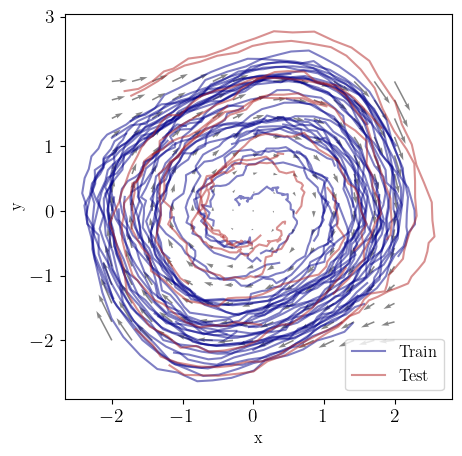

In [42]:
# generate trajectories for Noisy Van der Pol target system
set_seed(313)

system_name = 'noisy_vdp'
vdp_simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'noise_std': 0.75,  # Noise level for the simulation
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
}
vdp_system = VanDerPol(mu=vdp_simulation_params['mu'], noise_std=vdp_simulation_params['noise_std'])
time_span = torch.tensor([0.0, vdp_simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=vdp_simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=vdp_simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=vdp_simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=vdp_simulation_params['dt'], num_points=vdp_simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)
X, Y, U, V = get_ds_vf(vdp_system, bounds=[-2.0, 2.0], num_points=15)
set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(trajectories_target, train_ratio=.8)

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=50)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/vdpnoisy_vf_trajs.pdf", dpi=300, bbox_inches='tight')

np.save(f"{save_dir}/{system_name}.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(vdp_simulation_params, f)

In [ ]:
system_name = 'noisy_vdp'
noisy_vdp_folder = 'experiments/lcs/noisy_vdp'
os.makedirs(noisy_vdp_folder, exist_ok=True)
vdp_simulation_params = {'system': 'vdp',  'dim': 2, 'mu': 0.3, 'maxT': 5.0, 'num_points': 50, 'dt': 0.1, 'noise_std': 0.75, 'sampling_method': 'uniform', 'bounds': [(-2.0, 2.0)]*2}
time_span = torch.tensor([0.0, vdp_simulation_params['maxT']])
for noise_std in np.linspace(0., 1., 11):
    set_seed(313)
    vdp_simulation_params['noise_std'] = noise_std
    vdp_system = VanDerPol(mu=vdp_simulation_params['mu'], noise_std=vdp_simulation_params['noise_std'])
    t_values, trajectories_target, initial_conditions_target = generate_trajectories(sampling_method=vdp_simulation_params['sampling_method'],   
    noise_std=vdp_simulation_params['noise_std'], init_points_bounds=vdp_simulation_params['bounds'],                 
    time_span=time_span, dt=vdp_simulation_params['dt'], num_points=vdp_simulation_params['num_points'], system=vdp_system)

    np.save(f"{noisy_vdp_folder}/{system_name}_nstd{noise_std}.npy", trajectories_target.detach().numpy())
    with open(f"{noisy_vdp_folder}/{system_name}_simulation_params_nstd{noise_std}.pkl", "wb") as f:
        pickle.dump(vdp_simulation_params, f)

## Selkov

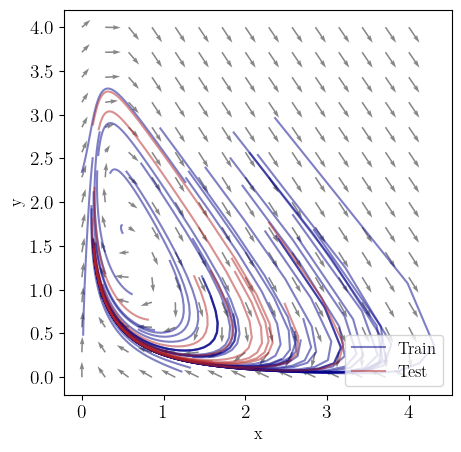

In [63]:
set_seed(313)

system_name = 'selkov'  #a \in [0.01, 0.11], b \in [0.02, 1.2]
simulation_params = {'system': 'selkov',  'dim': 2,
    'a': 0.05,'b': .5, 
    'maxT': 5.0, 'num_points': 50, 'dt': 0.1,  # Time step size
    'noise_std': 0.0, 'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(0, 3.0)]*2}
selkov_system = Selkov(a=simulation_params['a'], b=simulation_params['b'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(sampling_method=simulation_params['sampling_method'],        
    noise_std=simulation_params['noise_std'], init_points_bounds=simulation_params['bounds'], time_span=time_span, dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     
    system=selkov_system)
X, Y, U, V = get_ds_vf(selkov_system, bounds=[0, 4.0], num_points=15)
# U = U /(.5*X+Y)**1.5
# V = V /(.5*X+Y)**1.5
# normalize
U = U / (np.sqrt(U**2 + V**2) + 1e-10)
V = V / (np.sqrt(U**2 + V**2) + 1e-10)

set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(trajectories_target, train_ratio=.8)
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=25)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/selkov_vf_trajs.pdf", dpi=300, bbox_inches='tight')

np.save(f"{save_dir}/{system_name}.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(simulation_params, f)

## Lienard Sigmoid

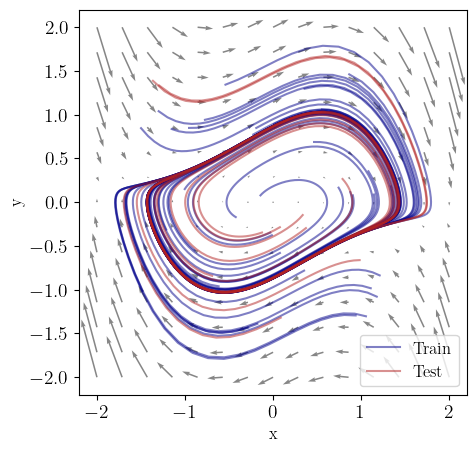

In [64]:
set_seed(313)

system_name = 'lienard_sigmoid'  #a \in [0, 1], b \in [-1, 1]
simulation_params = {'system': system_name,  'dim': 2,
    'a': 1.5,'b': -.5, 
    'maxT': 15.0, 'num_points': 50, 'dt': 0.1,  # Time step size
    'noise_std': 0.0, 'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-1.5, 1.5)]*2}
system = LienardSigmoid(a=simulation_params['a'], b=simulation_params['b'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(sampling_method=simulation_params['sampling_method'],        
    noise_std=simulation_params['noise_std'], init_points_bounds=simulation_params['bounds'], time_span=time_span, dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     
    system=system)
X, Y, U, V = get_ds_vf(system, bounds=[-2, 2], num_points=15)

set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(trajectories_target, train_ratio=.8)
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=50)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/lienard_vf_trajs.pdf", dpi=300, bbox_inches='tight')

np.save(f"{save_dir}/{system_name}.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(simulation_params, f)

## BZ Reaction

In [65]:
# set_seed(313)

# system_name = 'bz_reaction'  #a \in [2, 19], b \in [2, 6]
# simulation_params = {'system': system_name,  'dim': 2,
#     'a': 15,'b': 4, 
#     'maxT': 5.0, 'num_points': 50, 'dt': 0.05,  # Time step size
#     'noise_std': 0.0, 'sampling_method': 'uniform',  # Sampling method for initial conditions
#     'bounds': [(0, 5), (0,20)]}
# system = BZReaction(a=simulation_params['a'], b=simulation_params['b'])
# time_span = torch.tensor([0.0, simulation_params['maxT']])
# t_values, trajectories_target, initial_conditions_target = generate_trajectories(sampling_method=simulation_params['sampling_method'],        
#     noise_std=simulation_params['noise_std'], init_points_bounds=simulation_params['bounds'], time_span=time_span, dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     
#     system=system)
# X, Y, U, V = get_ds_vf(system, bounds=[0,20], num_points=15)

# fig, ax = plt.subplots(figsize=(5, 10))
# ax.quiver(X, Y, U, V, color='gray', alpha=0.5, scale=1000)
# for i in range(trajectories_target.shape[0]):
#     ax.plot(trajectories_target[i, :, 0].detach().numpy(), trajectories_target[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5)
# ax.set_xlabel('$x_1$')
# ax.set_ylabel('$x_2$')
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 20)

# np.save(f"{save_dir}/{system_name}.npy", trajectories_target.detach().numpy())
# with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
#     pickle.dump(simulation_params, f)

## Ring attractors

In [13]:
dim=2
dt = .2
noise_std = 0.0
time_span = torch.tensor([0.0, 2.])
analytic = True
vf_on_ring_enabled = True
training_pairs = False
alpha_init = None
ds_params = {'ds_motif': 'ring', 'dim': dim, 'dt': dt, 'time_span': time_span,'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
simulation_params = {'initial_conditions_mode': 'random','number_of_target_trajectories': 50,'time_span': time_span,'dt': dt,'noise_std': 0.0,'training_pairs': training_pairs,'margin': 0.5,'seed': 42,'ds_params': ds_params}
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
init_conds = prepare_initial_conditions(
    mode=simulation_params['initial_conditions_mode'],
    num_points=simulation_params['number_of_target_trajectories'],
    margin=simulation_params['margin'],
    seed=simulation_params['seed']
)
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
ra_trajs = ra_trajs.detach().numpy()
np.save(f"{save_dir}/ra.npy", ra_trajs)

### Homeomorphism-perturbed

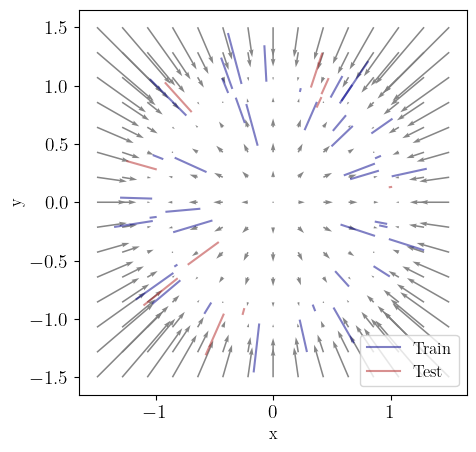

In [81]:
set_seed(313)
# Homeomorphism target
homeo_type = 'node'
target_layer_sizes = 1*[128]
homeo_mean = 0.02
homeo_std = 0.5
dim = 2
target_homeo_params = {
    'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': target_layer_sizes,
    'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std
}
target_homeo = build_homeomorphism(target_homeo_params)
interpol_value = 0.5
interpolated_homeo = rescale_node_vf(target_homeo, interpol_value)

dt = .2
time_span = torch.tensor([0.0, 2.])
ds_params = {
'ds_motif': 'ring', 'dim': dim, 'dt': dt, 'time_span': time_span,
'analytic': True, 'vf_on_ring_enabled': False,
'alpha_init': None, 'velocity_init': None
}

simulation_params = {
'initial_conditions_mode': 'random',
'number_of_target_trajectories': 50,
'time_span': time_span,
'dt': dt,
'noise_std': 0.0,
'margin': 0.5,
'seed': 42,
'ds_params': ds_params
}

generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span)
init_conds = prepare_initial_conditions(
    mode=simulation_params['initial_conditions_mode'],
    num_points=simulation_params['number_of_target_trajectories'],
    margin=simulation_params['margin'],
    seed=simulation_params['seed']
)
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
trajectories_target_full = interpolated_homeo(ra_trajs)

X, Y, U, V = get_ds_vf(generator_ra, bounds=[-1.5, 1.5], num_points=15)
set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(ra_trajs, train_ratio=.8)
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=10)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/ra_vf_trajs.pdf", dpi=300, bbox_inches='tight')

np.save(f"{save_dir}/homeo_pert_ring.npy", trajectories_target_full.detach().numpy())

### Vector field-perturbed

In [12]:
dim = 2
maxT = 5
tsteps = maxT*20
max_perturbation_norm = .15
pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01, "random_seed": 313, "min_val_sim": 3, "n_grid": 40, "add_limit_cycle": False, "num_points_invman": 20,
                            "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}

p_norm = .07
pring_simulation_params['perturbation_norm'] = p_norm
X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 

np.save(f"{save_dir}/vf_pert_ring.npy", trajectories_pertring)

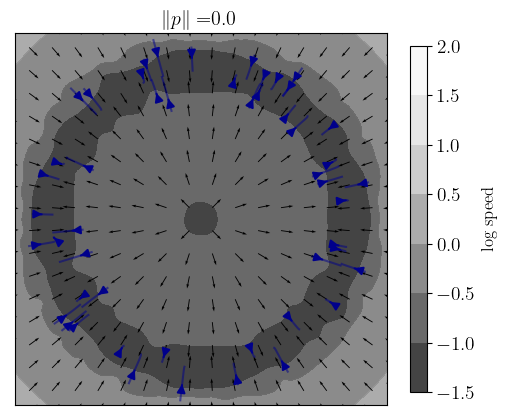

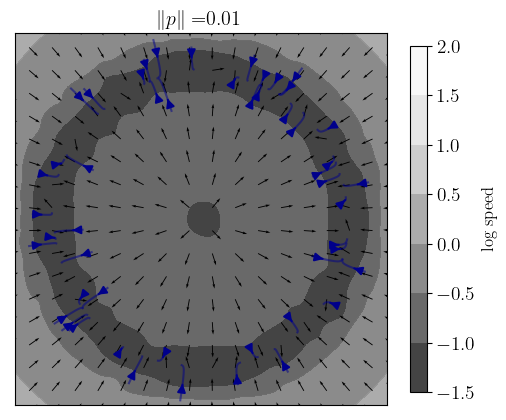

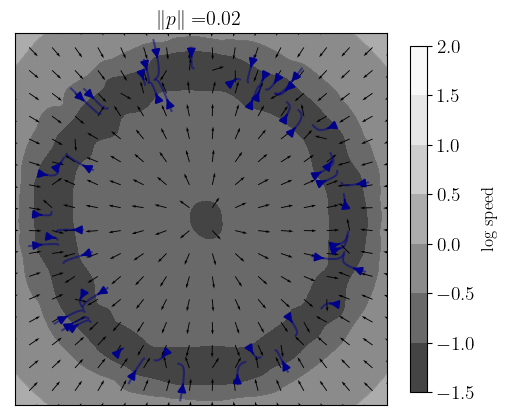

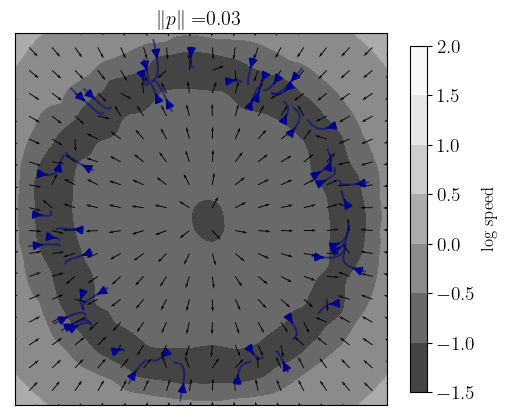

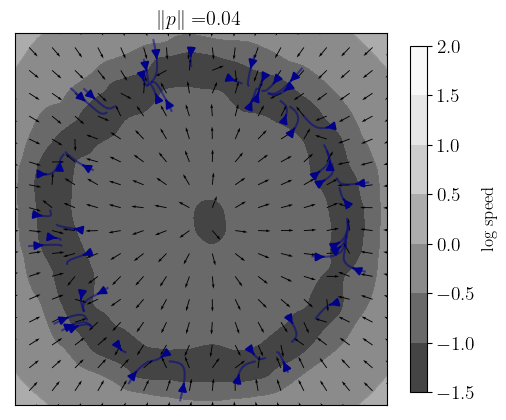

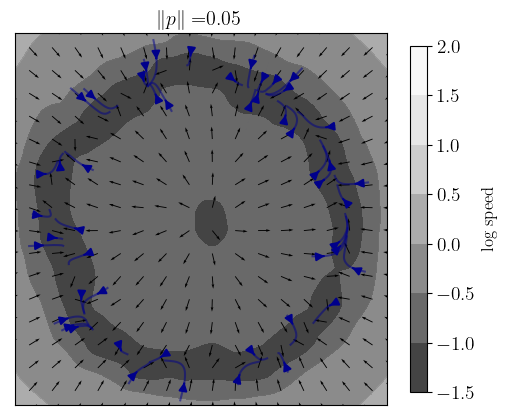

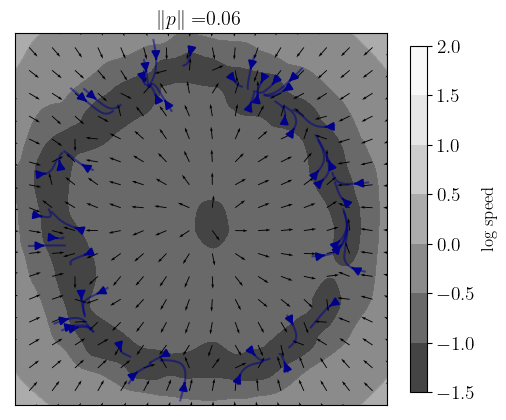

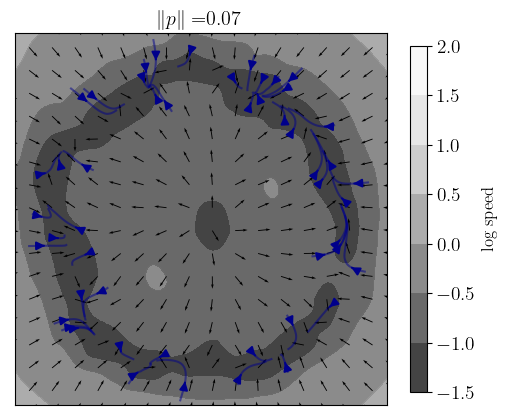

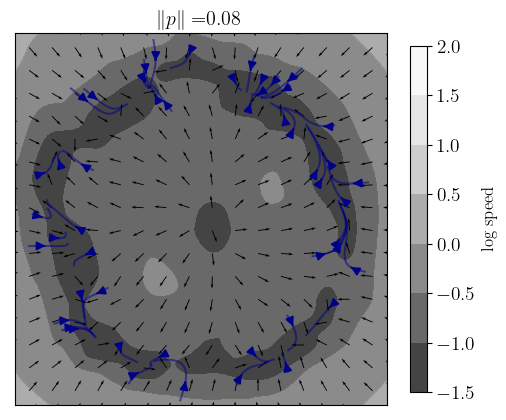

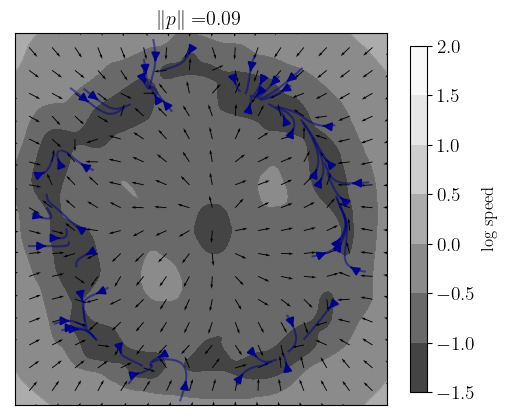

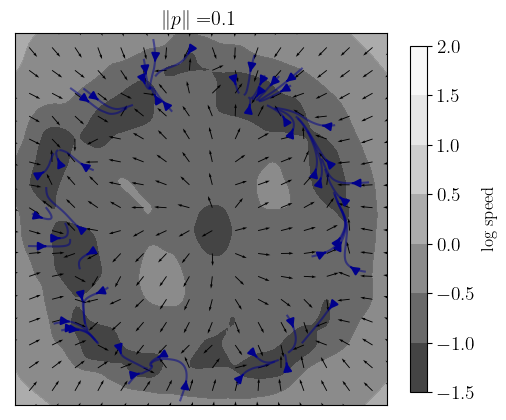

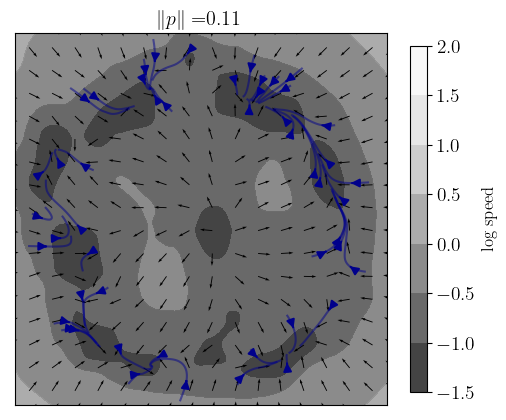

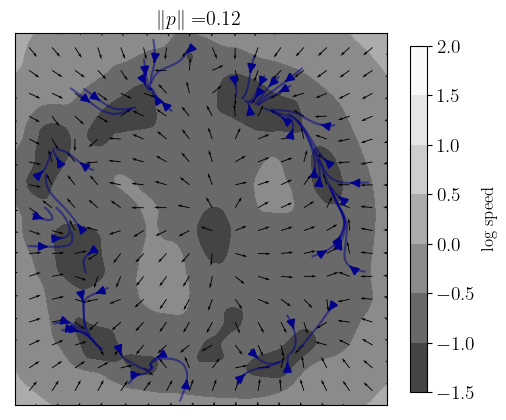

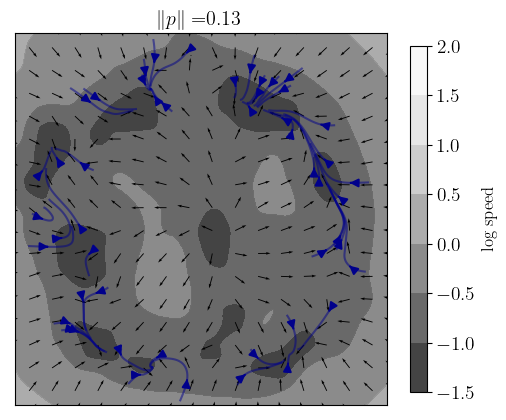

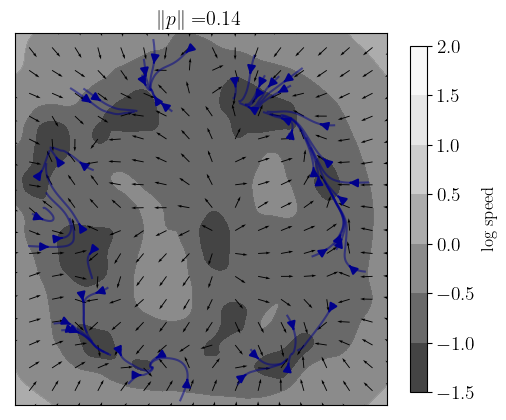

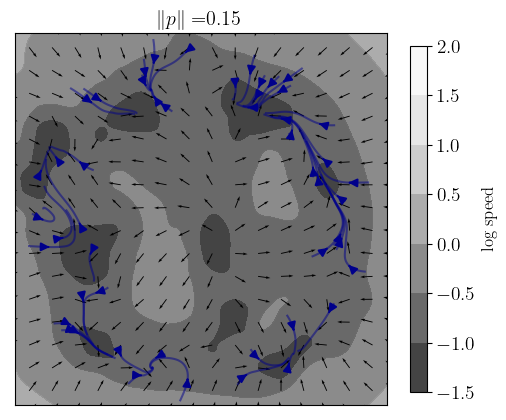

In [ ]:
# Plot the trajectories and vector field
save_dir = 'experiments/vf_pert_ring/vfs/'
for p_norm in np.arange(0.0, max_perturbation_norm + 0.001, 0.01):
    pring_simulation_params['perturbation_norm'] = p_norm
    X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
    
    # U = X * (1- np.sqrt(X**2 + Y**2))
    # V = Y * (1- np.sqrt(X**2 + Y**2))
    # plot_vector_field_fixedquivernorm_speedcontour(X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|p\|=${p_norm}", scale=1.0, color='teal', alpha=0.5, cmap='Greys_r', traj_color='darkblue', background_color='white', min_val_plot=1.25,
    #                                             vmin_log=-1.5, vmax_log=2, level_step=.5,
    #                                             save_name=f"{save_dir}/vf_pring_{p_norm}.pdf")

### Noisy ring

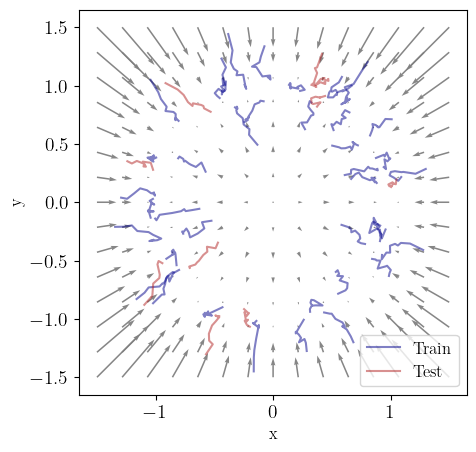

In [76]:
noise_std = 0.25
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
init_conds = prepare_initial_conditions(
    mode=simulation_params['initial_conditions_mode'],
    num_points=simulation_params['number_of_target_trajectories'],
    margin=simulation_params['margin'],
    seed=simulation_params['seed']
)
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
ra_trajs = ra_trajs

X, Y, U, V = get_ds_vf(generator_ra, bounds=[-1.5, 1.5], num_points=15)
set_seed(313)
trajectories_target_train, trajectories_target_test = split_data(ra_trajs, train_ratio=.8)
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=15)
for i in range(trajectories_target_train.shape[0]):
    ax.plot(trajectories_target_train[i, :, 0].detach().numpy(), trajectories_target_train[i, :, 1].detach().numpy(), color='darkblue', alpha=0.5, label='Train' if i==0 else "")
for i in range(trajectories_target_test.shape[0]):
    ax.plot(trajectories_target_test[i, :, 0].detach().numpy(), trajectories_target_test[i, :, 1].detach().numpy(), color='firebrick', alpha=0.5, label='Test' if i==0 else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
plt.savefig(f"{fig_dir}/ranoisy_vf_trajs.pdf", dpi=300, bbox_inches='tight')


np.save(f"{save_dir}/ra_nstd{noise_std}.npy", ra_trajs.detach().numpy())

## 2 Line attractors

# LC in 3D

In [ ]:

# generate trajectories for the target system
dt = 0.005
num_points = 50
dim = 3  
lorenz_system = LorenzSystem(dim=dim, sigma=10, rho=313, beta=8/3.)   #gaiko2014global
#lorenz_system = LorenzSystem(dim=dim, sigma=10, rho=600, beta=8/3.)   #gaiko2014global

noise_level = 0.
time_span = torch.tensor([0.0, 1.5])
init_points_bounds = [(40, 50), (80, 90), (300, 400)]  # 3D bounds

t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=init_points_bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=lorenz_system           # The target system, e.g., VanDerPol system
)

time_span = torch.tensor([0.0, .2])
initial_conditions = [trajectories_target[_, -4*_,:].clone().detach().numpy() for _ in range(num_points)] # Use the last point of the trajectory as the initial condition for the next trajectory
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    predefined_initial_conditions       =initial_conditions, # Predefined initial conditions for the target system
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=lorenz_system           # The target system, e.g., VanDerPol system
)

trajectories_target_centered = trajectories_target - trajectories_target.mean(dim=(0, 1), keepdim=True)
min_vals = trajectories_target_centered.amin(dim=(0, 1), keepdim=True)
max_vals = trajectories_target_centered.amax(dim=(0, 1), keepdim=True)

# Linearly scale to [-1, 1]
scaled = 2 * (trajectories_target_centered - min_vals) / (max_vals - min_vals) - 1
scaled_initial_conditions_target = scaled[:, 0, :]

np.save(f'{save_dir}/lorenz_off_313.npy', trajectories_target.detach().numpy())

c:\Users\abel_\Documents\Lab\Projects\topological_diversity\iam\scripts\ds_class.py:2050: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


# 2D attractors

### 